In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.stats import kendalltau

In [2]:
palette = np.array(['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:cyan',
              'tab:pink', 'gold', 'orange', 'yellowgreen', 'navy'])
MIN_SIZE_HSPOT, COEF_SIZE_HSPOT = 100, 5000
size_hspot = lambda T,Pmax: MIN_SIZE_HSPOT + COEF_SIZE_HSPOT*(T/Pmax)

class Simul:
    def __init__(self, params):
        self.P, self.Pmax = 0, params['Pmax']
        self.ell, self.mu, self.c, self.Nc = params['ell'], params['mu'], params['c'], params['Nc']
        self.div, self.hs = np.array(params['div']), params['house_size']
        self.L = self.div[0] * self.hs
        self.divratio = self.div[1] / self.div[0]
        
        self.spots = (self.div * np.random.rand(self.Nc,2)).astype(int) # 겹칠수가 있잖니?
        self.idx_hspots = np.array([],dtype=int)
        self.inhab = np.zeros((1,3),dtype=int)
        self.T = np.zeros(self.Nc)
        self.W = np.random.rand(self.Nc)
        
    def evalZ(self, ivec, j):
        d = self.hs * np.linalg.norm(ivec - self.spots[j])
        Z = self.W[j] - (d/self.ell)*(1 + (self.T[j]/self.c)**self.mu)
        return Z
    
    def getajob(self, ivec):
        j = 0
        Z = self.evalZ(ivec,j)
        for k in range(1, self.Nc):
            tempZ = self.evalZ(ivec,k)
            if tempZ > Z:
                j = k
                Z = tempZ
        return j
    
    def add(self):
        self.P += 1
        if self.P == self.Pmax: print('[Alert] Maximum Population Reached!')
        ivec = (self.div * np.random.rand(2)).astype(int) # 겹칠수가 있잖니?
        j = self.getajob(ivec)
        if not j in self.idx_hspots:
            self.idx_hspots = np.append(self.idx_hspots, j)
        self.T[j] += 1
        if self.P == 1:
            self.inhab[0] = np.append(ivec,j)
        else:
            self.inhab = np.append(self.inhab, [np.append(ivec,j)], axis=0)
        return self.inhab[-1], self.spots[j]

[Alert] Maximum Population Reached!


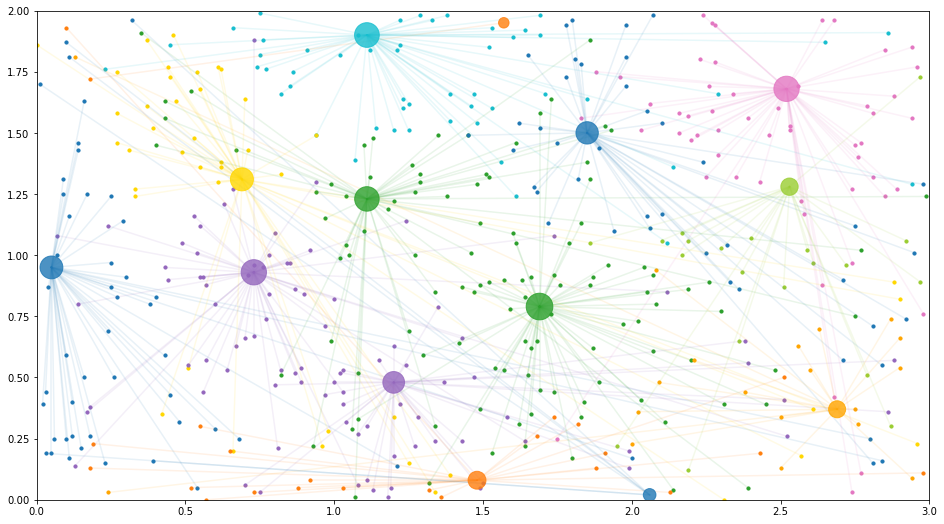

took : 3.2126975059509277 [sec]
<d> = 58.029735207028196 ... L/√k = 0.8017837257372732
ℓ/L 1666.6666666666667


In [3]:
params = {
    'Pmax' : 500,
    'ell' : 5000,
    'mu' : 2,
    'c' : 1,
    'Nc' : 50,
    'div' : (300, 200),
    'house_size' : 0.01
}
sim = Simul(params)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()
ax.set_xlim(0, sim.L)
ax.set_ylim(0, sim.L*sim.divratio)
darr = []

flag_start = time()
for n in range(sim.Pmax):
    newfren, newjob = sim.add()
    color = palette[newfren[2] % 9]
    darr.append(np.linalg.norm(newfren[:2] - newjob))
    
    ax.scatter(*sim.hs*newfren[:2], s=10, c=color)
    ax.plot(*sim.hs*np.vstack((newfren[:2], newjob)).T, color=color, alpha=0.1, zorder=1)
ax.scatter(*sim.hs*sim.spots[sim.idx_hspots].T,
           c=palette[sim.idx_hspots % 9],
           s=size_hspot(sim.T[sim.idx_hspots], sim.Pmax),
           alpha=0.8, zorder=2)
plt.show()
flag_end = time()

print('took :', flag_end - flag_start, '[sec]')
print('<d> =', np.mean(darr), '... L/√k =', sim.L / np.sqrt(len(sim.idx_hspots)) )
print('ℓ/L', sim.ell / sim.L)
# print('Ltot =', sum(darr))
# print('β =', 2 - 2*np.log(sum(darr))/np.log(sim.Pmax))

In [118]:
P_ceiling = int(1e+6)

params = {
    'Pmax' : P_ceiling,
    'ell' : 0,
    'mu' : 1,
    'c' : 5,
    'Nc' : 5,
    'div' : (100,100),
    'house_size' : 0.01
}
start = time()
elln_span = np.power(10, np.linspace(-4, 4, 30))
L = params['div'][0] * params['house_size']
rep = 100
P0_arr = np.zeros((len(elln_span), rep))
for i in range(rep):
    P0_stamps = []
    for ell in L*elln_span:
        params['ell'] = ell
        sim = Simul(params)

        P0 = 0
        for n in range(sim.Pmax):
            _,_ = sim.add()
            P0 = sim.P
            if len(sim.idx_hspots) > 1:
                break
        P0_stamps.append(P0)
    P0_arr[:,i] = P0_stamps.copy()
    L = sim.L

P0_avg = np.array([Pset.mean() for Pset in P0_arr]) - 1
P0_std = np.array([Pset.std() for Pset in P0_arr]) - 1
end = time()

print(end-start, 'sec')
print(sim.L)

121.95959091186523 sec
1.0


In [119]:
Y1, E1 = P0_avg, P0_std

In [84]:
Y2, E2 = P0_avg, P0_std

In [85]:
Y3, E3 = P0_avg, P0_std

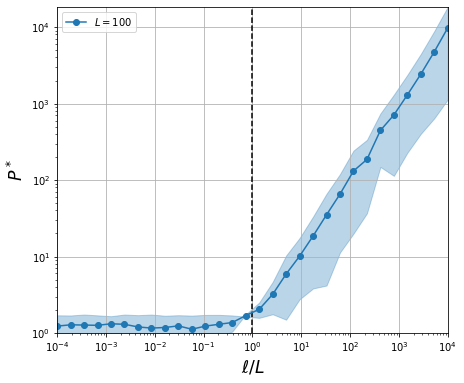

In [120]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(elln_span[0], elln_span[-1])
ax.set_ylim(1, max(Y1)+max(E1))
ax.set_xlabel('$\ell / L$', fontsize='xx-large')
ax.set_ylabel('$P^*$', fontsize='xx-large')
# ax.set_xticks([10**p for p in range(-5,5)])
# ax.xaxis.set_tick_params(labelsize=11)
# ax.yaxis.set_tick_params(labelsize=11)
ax.grid()

ax.axvline(x=1, c='k', ls='--')
ax.plot(elln_span, Y1, '-o', color=palette[0], label='$L=100$')
ax.fill_between(elln_span, Y1+E1, Y1-E1, color=palette[0], alpha=0.3)
# ax.plot(elln_span, Y2, '-o', color=palette[1], label='$L=1,000$')
# ax.fill_between(elln_span, Y2-E2, Y2+E2, color=palette[1], alpha=0.3)
# ax.plot(elln_span, Y3, '-o', color=palette[2], label='$L=10,000$')
# ax.fill_between(elln_span, Y3-E3, Y3+E3, color=palette[2], alpha=0.3)

ax.legend(loc='upper left')
plt.show()

In [121]:
output = np.vstack((elln_span, Y1, E1))
np.savetxt('anim_aux1.csv', output, delimiter=',')

In [147]:
params = {
    'Pmax' : 50000,
    'ell' : 0,
    'mu' : 4,
    'c' : 1,
    'Nc' : 30,
    'div' : (100,1),
    'house_size' : 1
}
L = params['div'][0] * params['house_size']
rep = 10
Telln_span = np.power(10, np.linspace(-4, 4, 30))

start = time()
TY, TE = [], []
for ell in L*Telln_span:
    taus = []
    for i in range(rep):
        params['ell'] = ell
        sim = Simul(params)
        while len(sim.idx_hspots) < sim.Nc:
            sim.add()
        X = sim.W[sim.idx_hspots].copy()
        Y = np.sort(sim.W)[::-1]
        tau, pval = kendalltau(X,Y)
        taus.append(tau)
    TY.append(np.mean(taus))
    TE.append(np.std(taus))
end = time()
print(end - start, 'sec')
TY = np.array(TY)
TE = np.array(TE)

8.641007423400879 sec


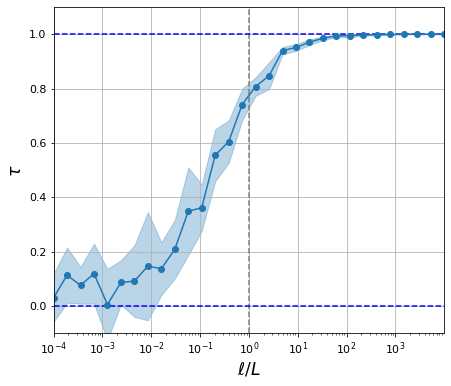

In [101]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_xscale('log')
ax.set_xlim(Telln_span[0], Telln_span[-1])
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('$\ell / L$', fontsize='xx-large')
ax.set_ylabel('$τ$', fontsize='xx-large')
ax.set_xticks([10**p for p in range(-4,4)])
ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=11)
ax.grid()

ax.axvline(x=1, c='gray', ls='--')
ax.axhline(y=0, c='blue', ls='--')
ax.axhline(y=1, c='blue', ls='--')
ax.plot(Telln_span, TY, '-o', color=palette[0], label='$L=0.1$')
ax.fill_between(Telln_span, TY-TE, TY+TE, color=palette[0], alpha=0.3)

plt.show()

In [42]:
params = {
    'Pmax' : 50000,
    'ell' : 0,
    'mu' : 4,
    'c' : 100,
    'Nc' : 10,
    'div' : (100,1),
    'house_size' : 1
}

L = params['div'][0] * params['house_size']
Delln_span = np.power(10, np.linspace(-4, 4, 20))
DY, DE = [], []

rep = 50
start = time()
for ell in L*Delln_span:
    dbarr = []
    for n in range(rep):
        params['ell'] = ell
        sim = Simul(params)
        darr = []
        while len(sim.idx_hspots) < sim.Nc:
            newfren, newjob = sim.add()
            darr.append(sim.hs * np.linalg.norm(newfren[:2] - newjob))
        dbarr.append(np.mean(darr))
    DY.append(np.mean(dbarr))
    DE.append(np.std(dbarr))
end = time()

rootk = np.sqrt(params['Nc'])
DY = rootk*np.array(DY)
DE = rootk*np.array(DE)
print(end - start, '[sec]')

255.42168974876404 [sec]


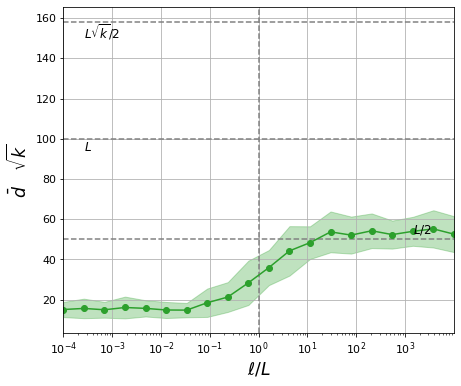

[1.00000000e-02 2.63665090e-02 6.95192796e-02 1.83298071e-01
 4.83293024e-01 1.27427499e+00 3.35981829e+00 8.85866790e+00
 2.33572147e+01 6.15848211e+01 1.62377674e+02 4.28133240e+02
 1.12883789e+03 2.97635144e+03 7.84759970e+03 2.06913808e+04
 5.45559478e+04 1.43844989e+05 3.79269019e+05 1.00000000e+06]


In [43]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_xscale('log')
ax.set_xlim(Delln_span[0], Delln_span[-1])
ax.set_xlabel('$ \\ell / L $', fontsize='xx-large')
ax.set_ylabel('$ \\bar{d} \\quad \\sqrt{k} $', fontsize='xx-large')
ax.set_xticks([10**p for p in range(-4,4)])
ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=11)
ax.grid()

ax.axvline(x=1, c='gray', ls='--')

ax.axhline(y=L/2, c='gray', ls='--')
ax.annotate('$L/2$', (Delln_span[-3], L/2 + 3), fontsize=12)

ax.axhline(y=(L/2)*rootk, c='gray', ls='--')
ax.annotate('$L\\sqrt{k}/2$', (Delln_span[1], (L/2)*rootk - 8), fontsize=12)

ax.axhline(y=L, c='gray', ls='--')
ax.annotate('$L$', (Delln_span[1], L - 6), fontsize=12)

ax.plot(Delln_span, DY, '-o', color=palette[1])
ax.fill_between(Delln_span, DY-DE, DY+DE, color=palette[1], alpha=0.3)

plt.show()
print(L*Delln_span)

In [38]:
params = {
    'Pmax' : 100000,
    'ell' : 10,
    'mu' : 4,
    'c' : 100,
    'Nc' : 10,
    'div' : (100,1),
    'house_size' : 1
}

L_span2 = np.power(10, np.linspace(-1, -5, 30))
DY2 = []

start = time()
for hs in L_span2 / params['div'][0]:
    params['house_size'] = hs
    sim = Simul(params)
    darr = []
    while len(sim.idx_hspots) < sim.Nc:
        newfren, newjob = sim.add()
        darr.append(hs * np.linalg.norm(newfren[:2] - newjob))
    DY2.append(np.mean(darr))
end = time()

print(end - start, '[sec]')

L_span3 = np.power(10, np.linspace(3, 8, 30))
DY3 = []

start = time()
for hs in L_span3 / params['div'][0]:
    params['house_size'] = hs
    sim = Simul(params)
    scaler = sim.L / sim.div
    darr = []
    while len(sim.idx_hspots) < sim.Nc:
        newfren, newjob = sim.add()
        darr.append(hs * np.linalg.norm(newfren[:2] - newjob))
    DY3.append(np.mean(darr))
end = time()

print(end - start, '[sec]')

39.617955923080444 [sec]
0.2958042621612549 [sec]


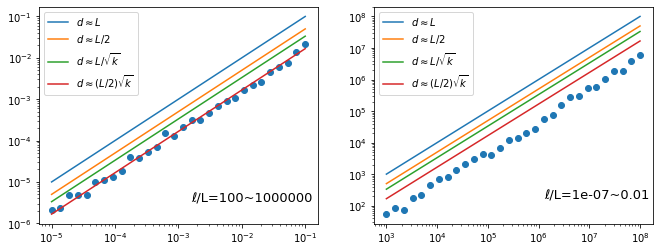

In [40]:
rootk = np.sqrt(params['Nc']-1)

fig, (ax,bx) = plt.subplots(1,2,figsize=(11,4))

ax.set_xscale('log')
ax.set_yscale('log')
ax.scatter(L_span2, np.array(DY2))

ax.plot(L_span2, L_span2, label='$d \\approx L$')
ax.plot(L_span2, L_span2/2, label='$d \\approx L/2$')
ax.plot(L_span2, L_span2/rootk, label='$d \\approx L/\\sqrt{k}$')
ax.plot(L_span2, L_span2/(2*rootk), label='$d \\approx (L/2) \\sqrt{k}$')

elln = params['ell'] / L_span2
elln_span = (str(int(min(elln))), str(round(max(elln))))
ax.annotate('ℓ/L='+'~'.join(elln_span), (L_span2[13], L_span2[-1]/3), fontsize=13)
ax.legend()

bx.set_xscale('log')
bx.set_yscale('log')
bx.scatter(L_span3, np.array(DY3))

bx.plot(L_span3, L_span3, label='$d \\approx L$')
bx.plot(L_span3, L_span3/2, label='$d \\approx L/2$')
bx.plot(L_span3, L_span3/rootk, label='$d \\approx L/\\sqrt{k}$')
bx.plot(L_span3, L_span3/(2*rootk), label='$d \\approx (L/2) \\sqrt{k}$')

elln = params['ell'] / L_span3
elln_span = (str(min(elln)), str(max(elln)))
bx.annotate('ℓ/L='+'~'.join(elln_span), (L_span3[18], L_span3[0]/6), fontsize=13)
bx.legend()

plt.show()

In [6]:
params = {
    'Pmax' : 1000000,
    'ell' : 0,
    'mu' : 0,
    'c' : 0,
    'Nc' : 0,
    'div' : (100,100),
    'house_size' : 0.01
}
parset = np.array([[1, 1, 10],
                   [10, 1, 10],
                   [1, 2, 10],
                   [1, 1, 100]])

sample = 5
rep = 10
X, Y, E = [], [], []
for s in parset:
    start = time()
    counter = 0
    
    params['c'], params['mu'], params['Nc'] = s
    X_sample = np.power(10, 1 + 3*np.random.rand(sample))
    
    P0_arr = []
    for x in X_sample:
        params['ell'] = s[2] * np.power(x/s[0], s[1])
        P0_arr_temp = []
        for n in range(rep):
            sim = Simul(params)
            while len(sim.idx_hspots) < 2:
                sim.add()
            P0_arr_temp.append(sim.P)
        counter += 1
        print(counter, '/', sample)
        P0_arr.append(np.mean(P0_arr_temp))
    X.append(X_sample)
    Y.append(P0_arr)
    
    end = time()
    print(end-start)

1 / 5
2 / 5
3 / 5
4 / 5
5 / 5
7.947613954544067
1 / 5
2 / 5
3 / 5
4 / 5
5 / 5
12.542803049087524
1 / 5
2 / 5
3 / 5
4 / 5
5 / 5
16.000450611114502
1 / 5
2 / 5
3 / 5
4 / 5
5 / 5
138.05493760108948


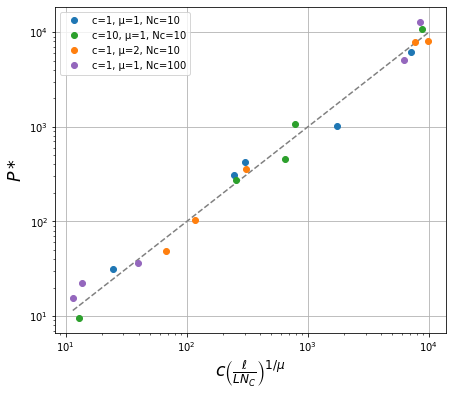

In [7]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim()
ax.set_xlabel('$ c \\left( \\frac{\\ell}{LN_C} \\right)^{1/\\mu} $', fontsize='xx-large')
ax.set_ylabel('$ P* $', fontsize='xx-large')
ax.grid()

minX = min([min(x) for x in X])
maxX = max([max(x) for x in X])
ax.plot([minX,maxX], [minX,maxX], color='gray', ls='--')

label_fmt = 'c={:d}, μ={:d}, Nc={:d}'
for i in range(len(parset)):
    label = label_fmt.format(*parset[i])
    ax.plot(X[i], Y[i], 'o', color=palette[i], label=label)

ax.legend()
plt.show()

In [210]:
params = {
    'Pmax' : 1e+7,
    'ell' : 1e-4,
    'mu' : 1,
    'c' : 1,
    'Nc' : 1000,
    'div' : (100,100),
    'house_size' : 0.01
}

muset = [2,3,4,5]
rep = 1
xdiv = 5
Xspan = np.power(10, np.linspace(0,3,xdiv))

Y = []
for mu in muset:
    counter = 0
    
    params['mu'] = mu
    kspan = 1 + np.power(Xspan, mu/(mu+1))
    print('..... k =', ','.join(kspan.astype(str)))
    
    Pk_arr = []
    for k in kspan:
        Pk_arr_temp = []
        start = time()
        for n in range(rep):
            sim = Simul(params)
            P0 = 0
            while len(sim.idx_hspots) < k:
                sim.add()
                if len(sim.idx_hspots) == 2:
                    P0 = sim.P
            Pk_arr_temp.append(sim.P / P0)
        end = time()
        Pk_arr.append(np.mean(Pk_arr_temp))
        print(k, ',', end-start, 'sec')
    Y.append(Pk_arr)

[1] k = 2.0,4.162277660168379,10.999999999999998,32.62277660168378,100.99999999999997
2.0 , 0.099761962890625 sec
4.162277660168379 , 0.7183747291564941 sec
10.999999999999998 , 2.8204538822174072 sec
32.62277660168378 , 17.67737102508545 sec
100.99999999999997 , 128.74784779548645 sec
[1] k = 2.0,4.651741272548377,14.33521432163324,49.69675251658631,178.82794100389228
2.0 , 0.031173229217529297 sec
4.651741272548377 , 0.18748807907104492 sec
14.33521432163324 , 1.5048255920410156 sec
49.69675251658631 , 7.273825168609619 sec
178.82794100389228 , 54.37401294708252 sec
[1] k = 2.0,4.981071705534973,16.848931924611136,64.09573444801933,252.1886431509581
2.0 , 0.031244754791259766 sec
4.981071705534973 , 0.14246606826782227 sec
16.848931924611136 , 0.7830018997192383 sec
64.09573444801933 , 5.2823474407196045 sec
252.1886431509581 , 33.998539447784424 sec
[1] k = 2.0,5.216965034285823,18.78279410038923,75.9894209332456,317.227766016838
2.0 , 0.015548467636108398 sec
5.216965034285823 , 0.

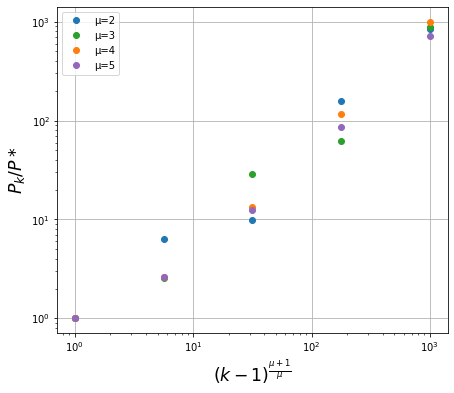

In [213]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim()
ax.set_xlabel('$ (k-1)^{\\frac{\\mu+1}{\\mu}} $', fontsize='xx-large')
ax.set_ylabel('$ P_k / P* $', fontsize='xx-large')
ax.grid()

for i in range(len(muset)):
    label = 'μ=' + str(muset[i])
    ax.plot(Xspan, Y[i], 'o', color=palette[i], label=label)
ax.legend()

plt.show()

In [13]:
params = {
    'Pmax' : 1e+7,
    'ell' : 1e-4,
    'mu' : 1,
    'c' : 1,
    'Nc' : 1000,
    'div' : (100,100),
    'house_size' : 0.01
}

muset = [2,3,4,5] # 다양하게 시도해볼 것
rep = 1
xdiv = 50
Xspan = np.power(10, np.linspace(1,3,xdiv))

process_div = 4
part = lambda i: np.floor(process_div*i/xdiv)

Y = []
for mu in muset:
    counter = 0
    params['mu'] = mu
    Pk_arr = []
    print('[', counter, '] (μ = ', mu, ')')
    
    cur_part = 0
    start = time()
    for i,k in enumerate(Xspan): # Notice k is float here
        Pk_arr_temp = []
        for n in range(rep):
            sim = Simul(params)
            P0 = 0
            while len(sim.idx_hspots) < k:
                sim.add()
                if len(sim.idx_hspots) == 2:
                    P0 = sim.P
            Pk_arr_temp.append(sim.P / P0)
        Pk_arr.append(np.mean(Pk_arr_temp))
        
        tmp_part = cur_part
        cur_part = part(i)
        if tmp_part != cur_part:
            print('...', cur_part*(100/process_div), '%')
    end = time()
    counter +=1
    print('OK!', end-start, 'sec')
    Y.append(Pk_arr)

[ 0 ] (μ =  2 )
... 25.0 %
... 50.0 %
... 75.0 %
OK! 107.92954134941101 sec
[ 0 ] (μ =  3 )
... 25.0 %
... 50.0 %
... 75.0 %
OK! 111.35745048522949 sec
[ 0 ] (μ =  4 )
... 25.0 %
... 50.0 %
... 75.0 %
OK! 111.02822303771973 sec
[ 0 ] (μ =  5 )
... 25.0 %
... 50.0 %
... 75.0 %
OK! 105.81932187080383 sec


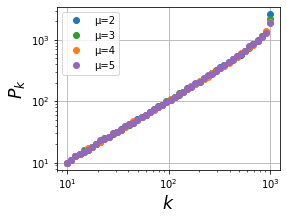

In [18]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim()
ax.set_xlabel('$ k $', fontsize='xx-large')
ax.set_ylabel('$ P_k $', fontsize='xx-large')
ax.grid()

for i in range(len(muset)):
    label = 'μ=' + str(muset[i])
    ax.plot(Xspan, [2*y for y in Y[i]], 'o', color=palette[i], label=label)
ax.legend()

plt.show()